<a href="https://colab.research.google.com/github/abhir8008/python-ds/blob/master/pytorch_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
transform = transforms.ToTensor()


In [3]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [8]:
#1 colour channel, 6 filters(output Channels), 3by3 Kernel,stride=1
conv1 = nn.Conv2d(1,6,3,1)

#6 input filters conv1,16 filters, 3by3, stride=1
conv2 = nn.Conv2d(6,16,3,1)

In [9]:
for i, (X_train,y_train) in enumerate(train_data):
  break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x=X_train.view(1,1,28,28) # 4D batch (batch of 1 image)

In [12]:
x = F.relu(conv1(x))

In [13]:
x.shape #no information on boader so no padding i.e, 28 to 26

torch.Size([1, 6, 26, 26])

In [14]:
x = F.max_pool2d(x,2,2)

In [15]:
x.shape #devide by 2, i.e, 26 to 13

torch.Size([1, 6, 13, 13])

In [16]:
x = F.relu(conv2(x))

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x,2,2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
x.view(-1,16*5*5).shape #flat layer -1 means keep the first dimension

torch.Size([1, 400])

## Model and Training

In [21]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16,120) # calculate by yourself
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10) #10 classes as output

  def forward(self,X):  # for activation function and pooling
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,16*5*5)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)         # no activation as last layer
    return F.log_softmax(X,dim=1)

In [22]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [25]:
import time
start_time = time.time()

# Variables Tracker
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For Loop Epoches
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0
  # Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train) # y_prediction or y_training k bech me matching

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum() #True 1/False 0 sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 ==0:
      print(f"EPOCH: {i} BATCH {b} LOSS: {loss.item()} ")

  train_losses.append(loss)
  train_correct.append(trn_corr)


    # Test
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):

      y_val = model(X_test)

      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()
  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)
  print(f'Test accuracy: {tst_corr.item()}/{len(test_data)} = {tst_corr.item()*100/(len(test_data)):7.3f}%')

current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH: 0 BATCH 600 LOSS: 0.04055628925561905 
EPOCH: 0 BATCH 1200 LOSS: 0.08253471553325653 
EPOCH: 0 BATCH 1800 LOSS: 0.3642270863056183 
EPOCH: 0 BATCH 2400 LOSS: 0.018563730642199516 
EPOCH: 0 BATCH 3000 LOSS: 0.008377513848245144 
EPOCH: 0 BATCH 3600 LOSS: 0.0024234906304627657 
EPOCH: 0 BATCH 4200 LOSS: 0.5999211072921753 
EPOCH: 0 BATCH 4800 LOSS: 0.022017866373062134 
EPOCH: 0 BATCH 5400 LOSS: 0.0071049341931939125 
EPOCH: 0 BATCH 6000 LOSS: 0.0580391064286232 
Test accuracy: 9769/10000 =  97.690%
EPOCH: 1 BATCH 600 LOSS: 0.012966835871338844 
EPOCH: 1 BATCH 1200 LOSS: 0.04782690852880478 
EPOCH: 1 BATCH 1800 LOSS: 0.0013526796828955412 
EPOCH: 1 BATCH 2400 LOSS: 0.022652272135019302 
EPOCH: 1 BATCH 3000 LOSS: 0.4363284707069397 
EPOCH: 1 BATCH 3600 LOSS: 0.000980690005235374 
EPOCH: 1 BATCH 4200 LOSS: 0.0007406159420497715 
EPOCH: 1 BATCH 4800 LOSS: 0.0005820695078000426 
EPOCH: 1 BATCH 5400 LOSS: 0.00035533643676899374 
EPOCH: 1 BATCH 6000 LOSS: 0.015377162024378777 
Test accu

In [30]:
'''
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label='validation_loss')
plt.title('Loss at epoches')
plt.legend()
'''

'\nplt.plot(train_losses,label="train_losses")\nplt.plot(test_losses,label=\'validation_loss\')\nplt.title(\'Loss at epoches\')\nplt.legend()\n'

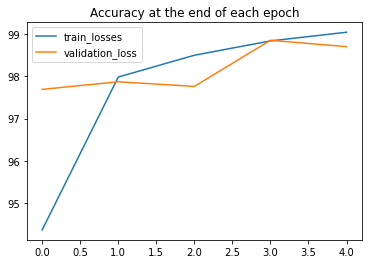

In [31]:
plt.plot([t/600 for t in train_correct],label="train_losses")
plt.plot([t/100 for t in test_correct],label='validation_loss')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [32]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9870/10000 =  98.700%
